In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import online_retail_analysis.utils.paths as path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,MiniBatchKMeans, AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

sns.set_style("whitegrid")
%matplotlib inline
pd.options.display.float_format = '{:,.3f}'.format

### Import data

In [3]:
df = pd.read_excel(path.data_raw_dir('Online Retail.xlsx')) 
#encoding = 'unicode_escape', engine ='python'
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
152435,549592,22766,PHOTO FRAME CORNICE,8,2011-04-11 10:14:00,2.950,"14,311.000",United Kingdom
136468,547964,22891,TEA FOR ONE POLKADOT,1,2011-03-28 15:45:00,8.290,NaN,United Kingdom
123565,546899,22661,CHARLOTTE BAG DOLLY GIRL DESIGN,50,2011-03-17 18:27:00,0.720,"14,298.000",United Kingdom
237804,557886,20684,STRAWBERRY DREAM CHILDS UMBRELLA,1,2011-06-23 13:39:00,3.250,"17,799.000",United Kingdom
180142,552305,23208,LUNCH BAG VINTAGE LEAF DESIGN,10,2011-05-08 15:16:00,1.650,"14,341.000",United Kingdom


### Check data

In [4]:
df.info()#see the information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [49]:
df_proces = df.copy() # create a copy the data
df_proces.isna().sum() # see the number of row whit NaN

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [50]:
df_proces[df_proces.isnull().any(axis=1)] # see the null data by columns

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.000,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.510,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.510,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.850,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.660,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.130,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.130,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.960,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.790,NaN,United Kingdom


In [51]:
df_proces.isnull().any(axis=0) # see null data from rows

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [52]:
df_proces.isnull().sum() # see all null data

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [53]:
df_proces = df_proces[pd.notnull(df_proces['CustomerID'])] # delete null data from Customer ID

In [54]:
df_proces.InvoiceNo.value_counts()

576339    542
579196    533
580727    529
578270    442
573576    435
         ... 
554155      1
570248      1
545414      1
545418      1
565192      1
Name: InvoiceNo, Length: 22190, dtype: int64

In [55]:
df_proces.duplicated().sum() #see the number of row duplicated

5225

In [56]:

df_proces.drop_duplicates(inplace=True) # remove the duplicated

df_proces.describe() # look the a little statistics 


,Quantity,UnitPrice,CustomerID
count,"401,604.000","401,604.000","401,604.000"
mean,12.183,3.474,"15,281.161"
std,250.283,69.764,"1,714.006"
min,"-80,995.000",0.000,"12,346.000"
25%,2.000,1.250,"13,939.000"
50%,5.000,1.950,"15,145.000"
75%,12.000,3.750,"16,784.000"
max,"80,995.000","38,970.000","18,287.000"


In [57]:
# delete Cancel transaccion 
df_proces['InvoiceNo'] = df_proces['InvoiceNo'].astype('str')
df_proces = df_proces[~df_proces['InvoiceNo'].str.contains('C')]

In [58]:
# delete Price and Quantity less than 0
df_proces = df_proces[df_proces.Quantity > 0]
df_proces = df_proces[df_proces.UnitPrice > 0]

In [59]:
print('Number of customers: {}'.format(len(df_proces.CustomerID.unique())))

print('Number of customers: {}'.format(len(df_proces.Country.unique())))

# df_proces.Country.value_counts()


Number of customers: 4338
Number of customers: 37


In [60]:
df_proces['date']= pd.to_datetime(df_proces['InvoiceDate'])
df_proces['month'] = df_proces['date'].dt.month
df_proces['days'] = df_proces['date'].dt.day_name()
df_proces

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,month,days
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,"17,850.000",United Kingdom,2010-12-01 08:26:00,12,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,"17,850.000",United Kingdom,2010-12-01 08:26:00,12,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,"17,850.000",United Kingdom,2010-12-01 08:26:00,12,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,"17,850.000",United Kingdom,2010-12-01 08:26:00,12,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,"17,850.000",United Kingdom,2010-12-01 08:26:00,12,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.850,"12,680.000",France,2011-12-09 12:50:00,12,Friday
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.100,"12,680.000",France,2011-12-09 12:50:00,12,Friday
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.150,"12,680.000",France,2011-12-09 12:50:00,12,Friday
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.150,"12,680.000",France,2011-12-09 12:50:00,12,Friday


### Remove outliers from price and quantity

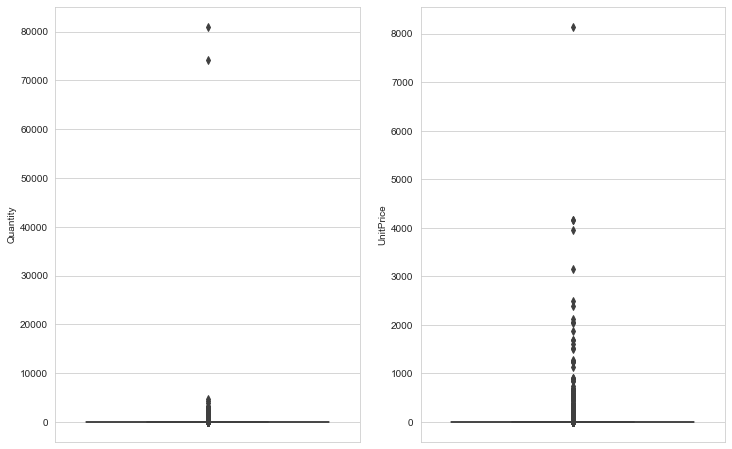

In [61]:
fig, axes= plt.subplots(1,2,figsize=(12,8))
sns.boxplot(y='Quantity', data=df_proces, ax=axes[0])
sns.boxplot(y='UnitPrice', data=df_proces, ax=axes[1])
plt.show()

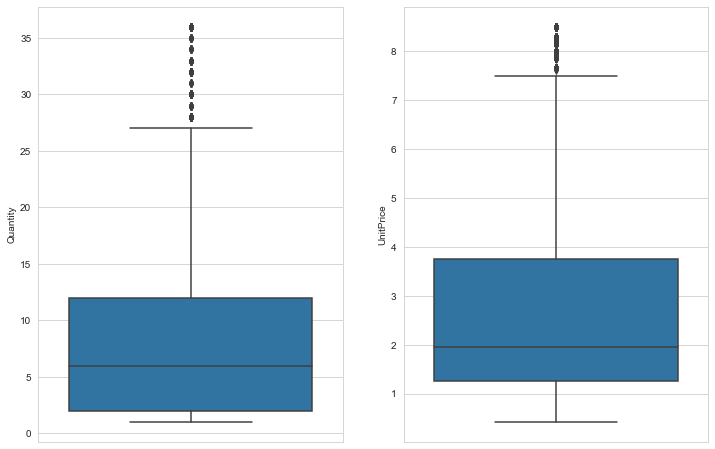

In [62]:
for col in ['Quantity','UnitPrice']:
    p_05 = df_proces[col].quantile(0.05) # 5th quantile
    p_95 = df_proces[col].quantile(0.95) # 95th quantile
    df_proces[col].clip(p_05, p_95, inplace=True)
fig, axes= plt.subplots(1,2,figsize=(12,8))
sns.boxplot(y='Quantity', data=df_proces, ax=axes[0])
sns.boxplot(y='UnitPrice', data=df_proces, ax=axes[1])
plt.show()

In [63]:
from online_retail_analysis.features.build_features import Calculate_RFM
df_rfm_labeling = Calculate_RFM(df_proces,labels=True)
df_rfm_labeling


,CustomerID,Recency,MonetaryValue,Frequency,R,F,M,RFM_score,RFM_Segment,label
0,"12,346.000",326,37.440,1,1,1,1,3,111,Lost Customers
1,"12,347.000",2,"4,015.210",182,4,4,4,12,444,Best Customers
2,"12,348.000",75,732.620,31,2,2,3,7,223,Customers Needing Attention
3,"12,349.000",19,"1,389.150",73,3,3,3,9,333,Potential Costumers
4,"12,350.000",310,302.900,17,1,1,2,4,112,At Risk Customers
...,...,...,...,...,...,...,...,...,...,...
4333,"18,280.000",278,177.700,10,1,1,1,3,111,Lost Customers
4334,"18,281.000",181,63.920,7,1,1,1,3,111,Lost Customers
4335,"18,282.000",8,162.250,12,4,1,1,6,411,Potential Costumers
4336,"18,283.000",4,"2,040.770",721,4,4,4,12,444,Best Customers


In [64]:
df_rfm_labeling['label'].value_counts()

Potential Costumers            1029
At Risk Customers               920
Loyal Custumers                 806
Customers Needing Attention     594
Best Customers                  466
Lost Customers                  407
Cant' Lose Them                  59
Others                           57
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='CustomerID'>

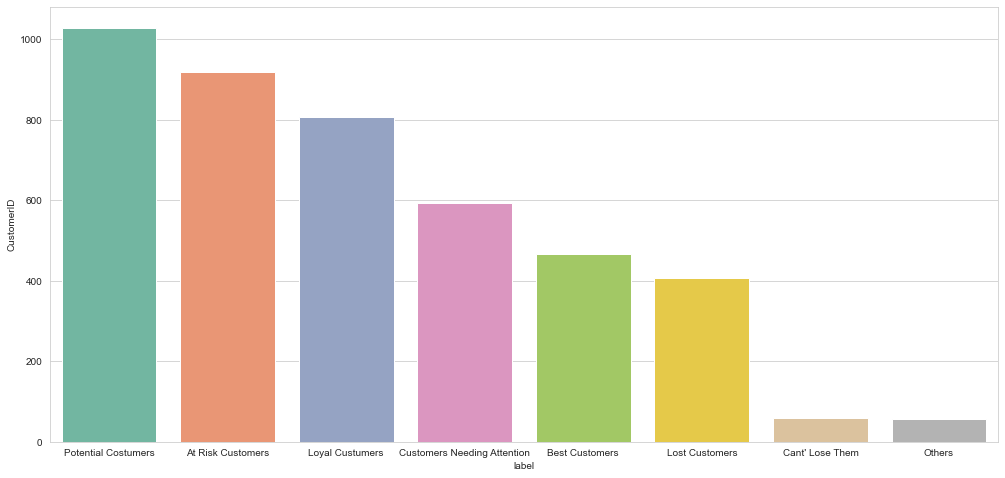

In [66]:
segmentation1=df_rfm_labeling.groupby('label')['CustomerID'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(17,8))
segmentation1.drop([0],inplace=False)
sns.barplot(data=segmentation1, x="label", y="CustomerID", palette = "Set2")

In [71]:
df_rfm = Calculate_RFM(df_proces,labels=False)

new_rfm = df_rfm.drop('CustomerID', axis=1)

new_rfm.head()

,Recency,MonetaryValue,Frequency
0,326,37.440,1
1,2,"4,015.210",182
2,75,732.620,31
3,19,"1,389.150",73
4,310,302.900,17


Recency's: Skew: 1.2456166142880103, : SkewtestResult(statistic=26.606793376917242, pvalue=5.664292789640091e-156)
Frequency's: Skew: 18.037289818570194, : SkewtestResult(statistic=83.48409612389142, pvalue=0.0)
MonetaryValue's: Skew: 15.601771569547436, : SkewtestResult(statistic=80.28950985442403, pvalue=0.0)


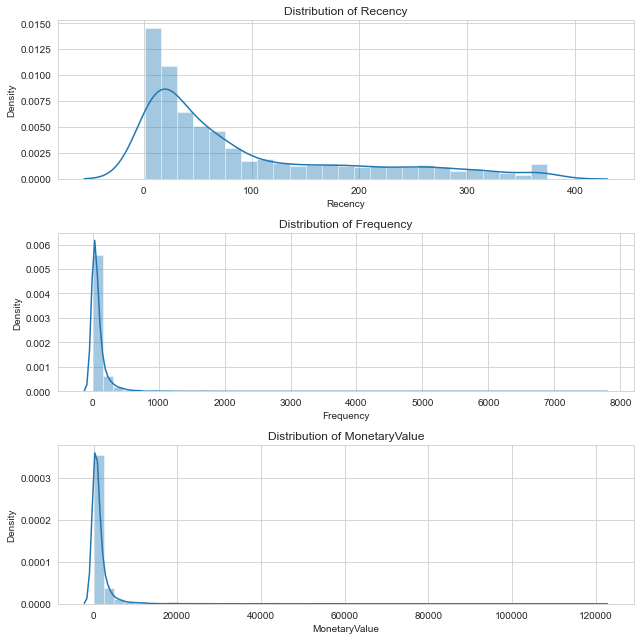

In [69]:
from online_retail_analysis.features.build_features import check_skew

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(new_rfm,'Recency')

plt.subplot(3, 1, 2)
check_skew(new_rfm,'Frequency')

plt.subplot(3, 1, 3)
check_skew(new_rfm,'MonetaryValue')

plt.tight_layout()
plt.savefig(path.reports_figures_dir('before_transform.png'), format='png', dpi=1000)


Recency's: Skew: -0.5543745693187032, : SkewtestResult(statistic=-13.977010237185045, pvalue=2.1534611206609193e-44)
Frequency's: Skew: -0.21789311915893791, : SkewtestResult(statistic=-5.801761082598964, pvalue=6.5622020042075114e-09)
MonetaryValue's: Skew: 0.11075063582635992, : SkewtestResult(statistic=2.974037445130544, pvalue=0.0029390920654637667)


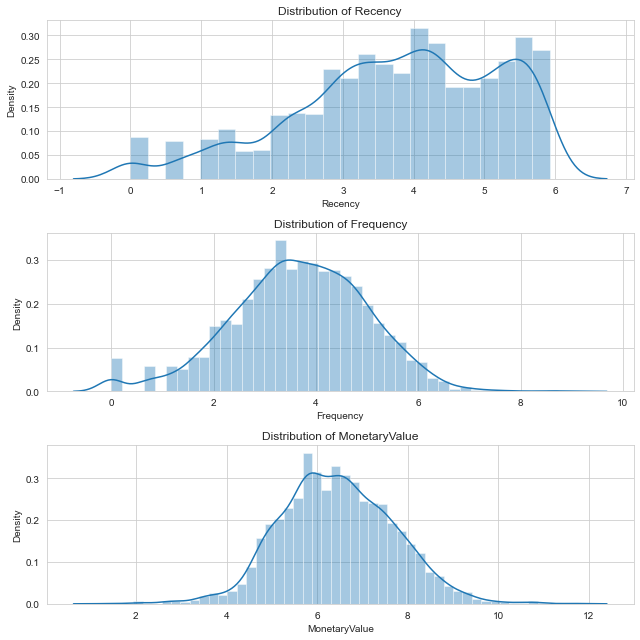

In [100]:
from sklearn.preprocessing import FunctionTransformer ,StandardScaler
transformer = FunctionTransformer(np.log)
new_rfm_trans_log = transformer.fit_transform(new_rfm)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(new_rfm_trans_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(new_rfm_trans_log,'Frequency')

plt.subplot(3, 1, 3)
check_skew(new_rfm_trans_log,'MonetaryValue')

plt.tight_layout()
plt.savefig(path.reports_figures_dir('after_transform.png'), format='png', dpi=1000)

In [99]:
new_rfm_trans_log.describe()

,Recency,MonetaryValue,Frequency
count,"4,338.000","4,338.000","4,338.000"
mean,3.768,6.444,3.672
std,1.432,1.248,1.321
min,0.000,1.322,0.000
25%,2.890,5.607,2.833
50%,3.932,6.401,3.714
75%,4.956,7.296,4.585
max,5.924,11.700,8.946


In [102]:

scaler = StandardScaler()
new_rfm_trans_log_sc = scaler.fit_transform(new_rfm_trans_log)
new_rfm_trans_log_sc
new_rfm_trans_log_sc = pd.DataFrame(new_rfm_trans_log_sc, columns=new_rfm_trans_log.columns)
new_rfm_trans_log_sc

,Recency,MonetaryValue,Frequency
0,1.410,-2.261,-2.780
1,-2.146,1.485,1.160
2,0.384,0.122,-0.180
3,-0.575,0.635,0.469
4,1.375,-0.586,-0.635
...,...,...,...
4333,1.299,-1.013,-1.037
4334,0.999,-1.832,-1.307
4335,-1.179,-1.086,-0.898
4336,-1.663,0.943,2.203


Recency's: Skew: -0.5543745693187032, : SkewtestResult(statistic=-13.977010237185045, pvalue=2.1534611206609193e-44)
Frequency's: Skew: -0.2178931191589386, : SkewtestResult(statistic=-5.801761082598983, pvalue=6.562202004206792e-09)
MonetaryValue's: Skew: 0.11075063582635862, : SkewtestResult(statistic=2.97403744513051, pvalue=0.0029390920654640924)


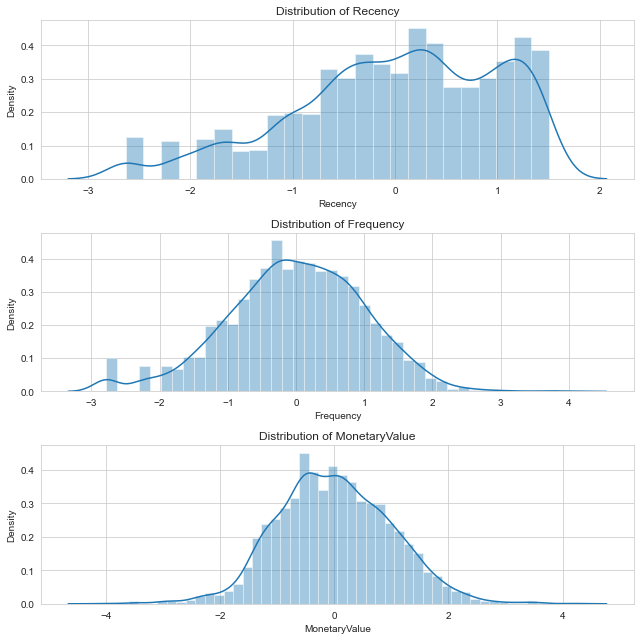

In [103]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(new_rfm_trans_log_sc,'Recency')

plt.subplot(3, 1, 2)
check_skew(new_rfm_trans_log_sc,'Frequency')

plt.subplot(3, 1, 3)
check_skew(new_rfm_trans_log_sc,'MonetaryValue')

plt.tight_layout()
plt.savefig(path.reports_figures_dir('after_transform_Scaler.png'), format='png', dpi=1000)

In [106]:
from sklearn.cluster import MiniBatchKMeans as KMeans
def train_elbow_cluster(train,start=1,finish=10,each=1):
    wcss = {} #dicionario vacio para guardar los errores
    for i in range(start,finish,each):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(train)
        wcss[i] = kmeans.inertia_ #suma de distancias cuadradas a los centros del grupos más cercanos
    plt.title('Metodo de Elbow ')
    plt.xlabel('k= n grupos')
    plt.ylabel('WCSS')
    sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
    plt.show()
#    return wcss 

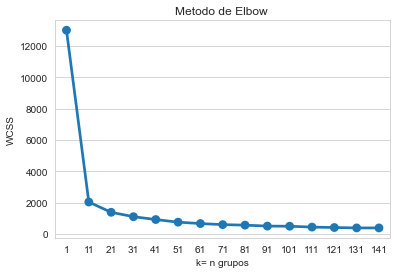

In [107]:
X = np.asarray(new_rfm_trans_log_sc)
train_elbow_cluster(X,finish=150,each=10)

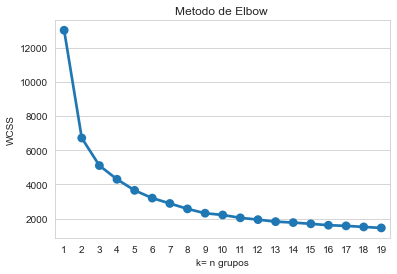

In [108]:
train_elbow_cluster(X,finish=20,each=1)